In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier
from IPython.core.interactiveshell import InteractiveShell
from scikitplot.metrics import plot_roc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBClassifier

# Setting styles
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

random_state = 123
init_points = 10
n_iter = 30


In [2]:

df = pd.read_csv(os.path.join("data", "processed", "training.csv"), index_col="ID")
df_validation = pd.read_csv(
    os.path.join("data", "processed", "validation.csv"), index_col="ID"
)

# Keeping only columns that credit rating agency would surely have
cols = ["credit_given", "sex", "education", "marriage", "age", "defaulted"]
df = df[cols]
df_validation = df_validation[cols]
# There are a few missing values and dropping them makes other stuff easier
# without affecting the amount of data much
df.dropna(inplace=True)
df_validation.dropna(inplace=True)
# many of our models can only handle numerical values so dummifying
df = pd.get_dummies(df, prefix=["sex", "education", "marriage"])
df_validation = pd.get_dummies(df_validation, prefix=["sex", "education", "marriage"])

X = df.drop(columns="defaulted")
y = df["defaulted"]

X_validation = df_validation.drop(columns="defaulted")
y_validation = df_validation["defaulted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)


In [3]:


def xgb_optimization(gamma, max_depth, cv=5):
    score = cross_val_score(
        XGBClassifier(
            objective="binary:logistic",
            gamma=max(gamma, 0),
            max_depth=int(max_depth),
            seed=random_state,
            nthread=-1,
        ),
        X=X_train,
        y=y_train,
        cv=cv,
        scoring="roc_auc",
        fit_params={
            "early_stopping_rounds": 10,
            "eval_metric": "auc",
            "eval_set": [(X_train, y_train), (X_test, y_test)],
        },
        n_jobs=-1,
    ).mean()

    return score


def rf_optimization(max_depth, min_samples_split, cv=5):
    score = cross_val_score(
        RandomForestClassifier(
            max_depth=int(max(max_depth, 1)),
            min_samples_split=int(max(min_samples_split, 2)),
            n_jobs=-1,
            random_state=random_state,
            class_weight="balanced",
        ),
        X=X_train,
        y=y_train,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
    ).mean()

    return score


def cat_optimization(depth, l2_leaf_reg, cv=5):
    score = cross_val_score(
        CatBoostClassifier(
            l2_leaf_reg=l2_leaf_reg,
            depth=int(depth),
            loss_function="Logloss",
            verbose=True,
            random_state=random_state,
        ),
        X=X_train,
        y=y_train,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
    ).mean()

    return score


def bayesian_optimization(function, parameters, n_iter, init_points):
    BO = BayesianOptimization(f=function, pbounds=parameters, random_state=random_state)
    BO.maximize(init_points=init_points, n_iter=n_iter)

    return BO.max



In [4]:

# can't add more parameters without changing the xgb_optimization function
xgb_parameters = {"gamma": (0, 20), "max_depth": (1, 2000)}

xgb_best_solution = bayesian_optimization(
    function=xgb_optimization,
    parameters=xgb_parameters,
    n_iter=n_iter,
    init_points=init_points,
)


|   iter    |  target   |   gamma   | max_depth |
-------------------------------------------------
|  1        |  0.6163   |  13.93    |  573.0    |
|  2        |  0.6152   |  4.537    |  1.103e+0 |
|  3        |  0.6152   |  14.39    |  846.8    |
|  4        |  0.6088   |  19.62    |  1.37e+03 |
|  5        |  0.6178   |  9.619    |  784.8    |
|  6        |  0.6177   |  6.864    |  1.458e+0 |
|  7        |  0.6187   |  8.771    |  120.3    |
|  8        |  0.6183   |  7.961    |  1.476e+0 |
|  9        |  0.6144   |  3.65     |  351.7    |
|  10       |  0.6179   |  10.63    |  1.064e+0 |
|  11       |  0.5903   |  0.3384   |  2e+03    |
|  12       |  0.6177   |  0.3007   |  1.742    |
|  13       |  0.591    |  0.02031  |  1.716e+0 |
|  14       |  0.6099   |  19.88    |  1.406    |
|  15       |  0.591    |  0.02594  |  958.8    |
|  16       |  0.6108   |  19.99    |  702.6    |
|  17       |  0.6108   |  19.96    |  1.888e+0 |
|  18       |  0.6108   |  19.89    |  459.6    |


In [5]:

# can't add more parameters without changing the optimization function
rf_parameters = {"max_depth": (1, 150), "min_samples_split": (2, 10)}

rf_best_solution = bayesian_optimization(
    function=rf_optimization,
    parameters=rf_parameters,
    n_iter=n_iter,
    init_points=init_points,
)


|   iter    |  target   | max_depth | min_sa... |
-------------------------------------------------
|  1        |  0.5611   |  104.8    |  4.289    |
|  2        |  0.5657   |  34.8     |  6.411    |
|  3        |  0.5635   |  108.2    |  5.385    |
|  4        |  0.5669   |  147.1    |  7.479    |
|  5        |  0.5635   |  72.66    |  5.137    |
|  6        |  0.5669   |  52.13    |  7.832    |
|  7        |  0.5591   |  66.35    |  2.477    |
|  8        |  0.5669   |  60.31    |  7.904    |
|  9        |  0.5612   |  28.19    |  3.404    |
|  10       |  0.5657   |  80.2     |  6.255    |
|  11       |  0.6013   |  1.063    |  9.982    |
|  12       |  0.6013   |  1.011    |  9.963    |
|  13       |  0.6013   |  1.125    |  9.932    |
|  14       |  0.6013   |  1.026    |  9.988    |
|  15       |  0.6013   |  1.255    |  9.915    |
|  16       |  0.6013   |  1.145    |  9.883    |
|  17       |  0.6013   |  1.087    |  9.979    |
|  18       |  0.6013   |  1.259    |  9.967    |


In [6]:

# can't add more parameters without changing the optimization function
cat_parameters = {"depth": (4, 10), "l2_leaf_reg": (2, 4)}

cat_best_solution = bayesian_optimization(
    function=cat_optimization,
    parameters=cat_parameters,
    n_iter=n_iter,
    init_points=init_points,
)



|   iter    |  target   |   depth   | l2_lea... |
-------------------------------------------------
|  1        |  0.5989   |  8.179    |  2.572    |
|  2        |  0.6129   |  5.361    |  3.103    |
|  3        |  0.5994   |  8.317    |  2.846    |
|  4        |  0.5956   |  9.885    |  3.37     |
|  5        |  0.6085   |  6.886    |  2.784    |
|  6        |  0.6094   |  6.059    |  3.458    |
|  7        |  0.6092   |  6.631    |  2.119    |
|  8        |  0.6083   |  6.388    |  3.476    |
|  9        |  0.6128   |  5.095    |  2.351    |
|  10       |  0.6038   |  7.189    |  3.064    |
|  11       |  0.616    |  4.003    |  3.996    |
|  12       |  0.6162   |  4.013    |  2.014    |
|  13       |  0.6157   |  4.004    |  2.01     |
|  14       |  0.6165   |  4.001    |  3.997    |
|  15       |  0.6165   |  4.009    |  2.007    |
|  16       |  0.6163   |  4.006    |  3.971    |
|  17       |  0.6156   |  4.003    |  2.015    |
|  18       |  0.6162   |  4.01     |  3.992    |


In [7]:

params = xgb_best_solution["params"]
xgb_model = XGBClassifier(
    objective="binary:logistic",
    gamma=int(max(params["gamma"], 0)),
    max_depth=int(max(params["max_depth"], 1)),
    seed=random_state,
    nthread=-1,
)


xgb_model.fit(X, y)

xgb_pred_train = xgb_model.predict_proba(X)
xgb_pred_validation = xgb_model.predict_proba(X_validation)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=8, learning_rate=0.1,
       max_delta_step=0, max_depth=120, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=123, silent=None, subsample=1, verbosity=1)

In [8]:

params = rf_best_solution["params"]
rf_model = RandomForestClassifier(
    max_depth=int(max(params["max_depth"], 1)),
    min_samples_split=int(max(params["min_samples_split"], 2)),
    n_jobs=-1,
    random_state=random_state,
    class_weight="balanced",
)

rf_model.fit(X, y)

rf_pred_train = rf_model.predict_proba(X)
rf_pred_validation = rf_model.predict_proba(X_validation)


/home/tuomo/anaconda3/envs/credit-risk-prediction/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=1, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=9, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

In [9]:

params = cat_best_solution["params"]
cat_model = CatBoostClassifier(
    l2_leaf_reg=params["l2_leaf_reg"],
    depth=int(params["depth"]),
    loss_function="Logloss",
    verbose=False,
    random_state=random_state,
)

cat_model.fit(X, y)

cat_pred_train = cat_model.predict_proba(X)
cat_pred_validation = cat_model.predict_proba(X_validation)


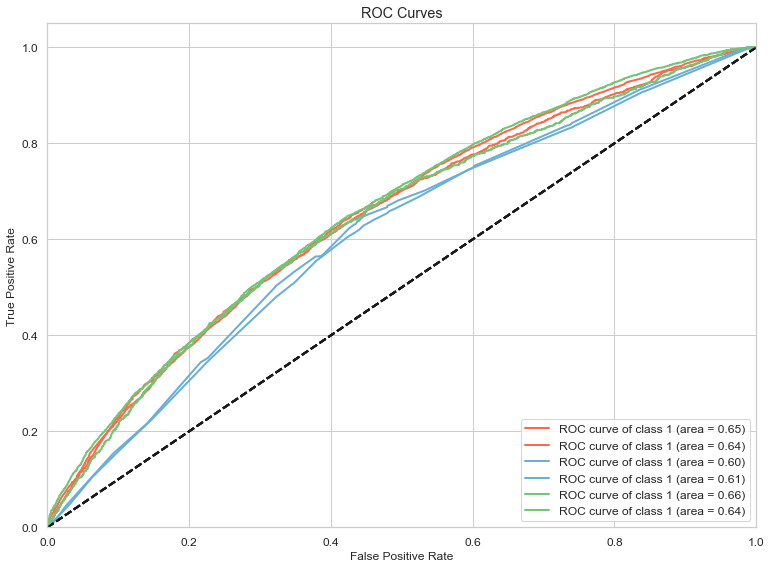

In [10]:


fig, ax = plt.subplots()
plot_roc(
    y,
    xgb_pred_train,
    plot_micro=False,
    plot_macro=False,
    title="ROC Curves",
    classes_to_plot=[1],
    ax=ax,
    figsize=None,
    cmap="Reds",
)
plot_roc(
    y_validation,
    xgb_pred_validation,
    plot_micro=False,
    plot_macro=False,
    classes_to_plot=[1],
    ax=ax,
    figsize=None,
    cmap="Reds",
)
plot_roc(
    y,
    rf_pred_train,
    plot_micro=False,
    plot_macro=False,
    classes_to_plot=[1],
    ax=ax,
    figsize=None,
    cmap="Blues",
)
plot_roc(
    y_validation,
    rf_pred_validation,
    plot_micro=False,
    plot_macro=False,
    classes_to_plot=[1],
    ax=ax,
    figsize=None,
    cmap="Blues",
)
plot_roc(
    y,
    cat_pred_train,
    plot_micro=False,
    plot_macro=False,
    classes_to_plot=[1],
    ax=ax,
    figsize=None,
    cmap="Greens",
)
plot_roc(
    y_validation,
    cat_pred_validation,
    plot_micro=False,
    plot_macro=False,
    classes_to_plot=[1],
    ax=ax,
    figsize=None,
    cmap="Greens",
)
plt.show()


In [11]:

with open(os.path.join("models", "xgboost_best_params.txt"), "w") as output_file:
    print(xgb_best_solution, file=output_file)

with open(os.path.join("models", "rf_best_params.txt"), "w") as output_file:
    print(rf_best_solution, file=output_file)

with open(os.path.join("models", "cat_best_params.txt"), "w") as output_file:
    print(cat_best_solution, file=output_file)
